# Specifying your own neural network with MNEflow

In [1]:
# Here we use the same dataset as in the basic mneflow example
from time import time
import mne
from mne.datasets import multimodal
import mneflow

mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
condition_names = [k for c in cond for k,v in c['event_id'].items()]

epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
#pick only planar gradiometers
epochs = epochs.pick_types(meg='grad')

In [2]:
#Specify import options
import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  val_size=0.15,  # validation set size set to 15% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')


##since meta file already exists and overwrite=False produce_tfrecords does not need to repeat the preprocessing
meta = mneflow.produce_tfrecords(epochs,**import_opt)  

processing epochs
input shapes: X- (940, 204, 361) targets- (940,)
training set: X- (799, 204, 302)  y- (799, 8)
validation set: X- (141, 204, 302)  y- (141, 8)
train preprocessed: (799, 1, 302, 204) (799, 8)
Prepocessed sample shape: (1, 302, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


In [3]:
#let's make a simple peceptron-like classifier using all channels*timepoints as features with keras
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.constraints import max_norm

class MyNetwork(mneflow.models.BaseModel):
    #In the simplest case all you need to do is to override the computational graph with your own
    def build_graph(self):
        self.scope = 'custom_model'
        flat = Flatten()(self.inputs)
        self.fc = Dense(units=8, activation="softmax")
        y_pred = self.fc(flat)
        return y_pred
    
    #the same can be done with Optimizer._set_optimizer method if you need to use a custom optimization pipeline  

In [5]:
graph_specs = dict(model_path=import_opt['savepath'],
                   dropout=0.)
dataset = mneflow.Dataset(meta, train_batch=100, class_subset=None, pick_channels=None, decim=None)
model = MyNetwork(dataset, graph_specs)
model.build()
model.train(n_epochs=5, eval_step=100, early_stopping=3)

ds batch size: 100
ds batch size: 142
setting batch size to default (100)
ds batch size: 100
Input shape: (1, 302, 204)
y_pred: (None, 8)
Initialization complete!
Train for 100 steps, validate for 1 steps
Epoch 1/5
100/100 [==============================] - 10s 101ms/step - loss: 1.4154 - accuracy: 0.8574 - val_loss: 1.7004 - val_accuracy: 0.5775
Epoch 2/5
100/100 [==============================] - 9s 91ms/step - loss: 1.3296 - accuracy: 0.9441 - val_loss: 1.6258 - val_accuracy: 0.6479
Epoch 3/5
100/100 [==============================] - 9s 94ms/step - loss: 1.3207 - accuracy: 0.9531 - val_loss: 1.5872 - val_accuracy: 0.6761
Epoch 4/5
100/100 [==============================] - 9s 92ms/step - loss: 1.3170 - accuracy: 0.9570 - val_loss: 1.6060 - val_accuracy: 0.6761
Epoch 5/5
100/100 [==============================] - 9s 87ms/step - loss: 1.3112 - accuracy: 0.9629 - val_loss: 1.6044 - val_accuracy: 0.6761


### Since our custom model inherits some methods from the parent class we can e.g. plot the confusion matrix easily

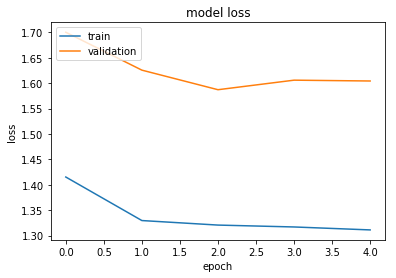

In [6]:
model.plot_hist()

